# U-Net 3D CT Segmentation

This notebook implements a 3D U-Net model for segmenting pelvis from CT scans.

## Setup and Imports

First, let's check our environment and dependencies.

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# Print versions for reproducibility
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
print(f"SimpleITK version: {sitk.__version__}")
print(f"NumPy version: {np.__version__}")

PyTorch version: 2.5.1
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4070
SimpleITK version: 2.4.0
NumPy version: 1.26.4


## 2. Data Exploration
Let's examine our dataset structure and visualize some samples.

In [3]:
# Define paths
data_dir = '../data'
images_path = os.path.join(data_dir, 'PENGWIN_CT_train_images')
labels_path = os.path.join(data_dir, 'PENGWIN_CT_train_labels')

# List and count files
image_files = sorted([f for f in os.listdir(images_path) if f.endswith('.mha')])
label_files = sorted([f for f in os.listdir(labels_path) if f.endswith('.mha')])

print(f"Found {len(image_files)} image files in {images_path}")
print(f"Found {len(label_files)} label files in {labels_path}")
print("\nFirst 5 image files:")
for f in image_files[:5]:
    print(f"- {f}")

# Load one sample to check dimensions
sample_image = sitk.ReadImage(os.path.join(images_path, image_files[0]))
sample_array = sitk.GetArrayFromImage(sample_image)
print(f"\nOriginal image dimensions: {sample_array.shape}")
print(f"Image spacing: {sample_image.GetSpacing()}")
print(f"Value range: [{sample_array.min():.2f}, {sample_array.max():.2f}] HU")

Found 100 image files in ../data\PENGWIN_CT_train_images
Found 100 label files in ../data\PENGWIN_CT_train_labels

First 5 image files:
- 001.mha
- 002.mha
- 003.mha
- 004.mha
- 005.mha

Original image dimensions: (401, 512, 512)
Image spacing: (0.78125, 0.78125, 0.800000011920929)
Value range: [-1023.00, 2775.00] HU


## 3. Dataset Implementation with Visualization

In [5]:
class CTScanDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None, target_shape=(1, 128, 128, 128)):
        self.image_paths = sorted([os.path.join(images_path, fname) 
                                 for fname in os.listdir(images_path) 
                                 if fname.endswith('.mha')])
        self.label_paths = sorted([os.path.join(labels_path, fname) 
                                 for fname in os.listdir(labels_path) 
                                 if fname.endswith('.mha')])
        
        assert len(self.image_paths) == len(self.label_paths)
        self.transform = transform
        self.target_shape = target_shape

    def pad_or_resize_to_shape(self, img, target_shape):
        current_shape = img.shape
        pad = [(0, max(0, target_shape[i] - current_shape[i])) 
               for i in range(len(target_shape))]
        img = np.pad(img, pad, mode='constant', constant_values=0)
        slices = tuple(slice(0, min(current_shape[i], target_shape[i])) 
                      for i in range(len(target_shape)))
        return img[slices]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load and process image
        image = sitk.GetArrayFromImage(sitk.ReadImage(self.image_paths[idx])).astype(np.float32)
        label = sitk.GetArrayFromImage(sitk.ReadImage(self.label_paths[idx])).astype(np.float32)
        
        # Preprocessing
        image = np.clip(image, -1000, 1000)
        image = (image + 1000) / 2000
        label = (label > 0).astype(np.float32)
        
        # Add channel dimension and adjust shape
        image = np.expand_dims(image, axis=0)
        label = np.expand_dims(label, axis=0)
        
        image = self.pad_or_resize_to_shape(image, self.target_shape)
        label = self.pad_or_resize_to_shape(label, self.target_shape)
        
        return torch.tensor(image), torch.tensor(label)

## 4. Model Architecture Visualization

In [6]:
class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()
        
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        def up_conv(in_ch, out_ch):
            return nn.ConvTranspose3d(in_ch, out_ch, kernel_size=2, stride=2)
        
        # Encoder
        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)
        
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        
        # Bottleneck
        self.bottleneck = conv_block(512, 1024)
        
        # Decoder
        self.upconv4 = up_conv(1024, 512)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = up_conv(512, 256)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = up_conv(256, 128)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = up_conv(128, 64)
        self.decoder1 = conv_block(128, 64)
        
        self.output = nn.Conv3d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Implementation remains the same as in your original code
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))
        
        b = self.bottleneck(self.pool(e4))
        
        d4 = self.upconv4(b)
        d4 = self.decoder4(torch.cat((e4, d4), dim=1))
        d3 = self.upconv3(d4)
        d3 = self.decoder3(torch.cat((e3, d3), dim=1))
        d2 = self.upconv2(d3)
        d2 = self.decoder2(torch.cat((e2, d2), dim=1))
        d1 = self.upconv1(d2)
        d1 = self.decoder1(torch.cat((e1, d1), dim=1))
        
        return self.output(d1)
    

show the parameter of the model

In [28]:

    def print_model_summary(model):
        """Print model architecture summary"""
        print("Model Architecture:")
        print("------------------")
        total_params = 0
        for name, param in model.named_parameters():
            param_count = param.numel()
            total_params += param_count
            print(f"{name}: {list(param.shape)} ({param_count:,} parameters)")
        print(f"\nTotal parameters: {total_params:,}")

    # Initialize model and print summary
    model = UNet3D(in_channels=1, out_channels=1)
    print_model_summary(model)

Model Architecture:
------------------
encoder1.0.weight: [64, 1, 3, 3, 3] (1,728 parameters)
encoder1.0.bias: [64] (64 parameters)
encoder1.2.weight: [64, 64, 3, 3, 3] (110,592 parameters)
encoder1.2.bias: [64] (64 parameters)
encoder2.0.weight: [128, 64, 3, 3, 3] (221,184 parameters)
encoder2.0.bias: [128] (128 parameters)
encoder2.2.weight: [128, 128, 3, 3, 3] (442,368 parameters)
encoder2.2.bias: [128] (128 parameters)
encoder3.0.weight: [256, 128, 3, 3, 3] (884,736 parameters)
encoder3.0.bias: [256] (256 parameters)
encoder3.2.weight: [256, 256, 3, 3, 3] (1,769,472 parameters)
encoder3.2.bias: [256] (256 parameters)
encoder4.0.weight: [512, 256, 3, 3, 3] (3,538,944 parameters)
encoder4.0.bias: [512] (512 parameters)
encoder4.2.weight: [512, 512, 3, 3, 3] (7,077,888 parameters)
encoder4.2.bias: [512] (512 parameters)
bottleneck.0.weight: [1024, 512, 3, 3, 3] (14,155,776 parameters)
bottleneck.0.bias: [1024] (1,024 parameters)
bottleneck.2.weight: [1024, 1024, 3, 3, 3] (28,311,552 p

## 5. Training Configuration and Progress Tracking

In [7]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Paths
data_dir = r'..\data'
images_path = os.path.join(data_dir, 'PENGWIN_CT_train_images')
labels_path = os.path.join(data_dir, 'PENGWIN_CT_train_labels')

# Hyperparameters
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
BATCH_SIZE = 2

# Dataset and DataLoader setup
train_transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = CTScanDataset(images_path, labels_path, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model initialization
model = UNet3D(in_channels=1, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

class TrainingMonitor:
    def __init__(self):
        self.train_losses = []
        self.current_epoch = 0
        
    def update(self, epoch_loss):
        self.train_losses.append(epoch_loss)
        self.current_epoch += 1
        
    def plot_progress(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.title('Training Progress')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()
        plt.show()
        
    def print_stats(self):
        print(f"Current epoch: {self.current_epoch}")
        print(f"Best loss: {min(self.train_losses):.4f}")
        print(f"Current loss: {self.train_losses[-1]:.4f}")

# Initialize training monitor
monitor = TrainingMonitor()

Using device: cuda


## 5. Training Loop

Epoch 5/50: 100%|██████████| 50/50 [32:55<00:00, 39.51s/it, loss=0.000305]


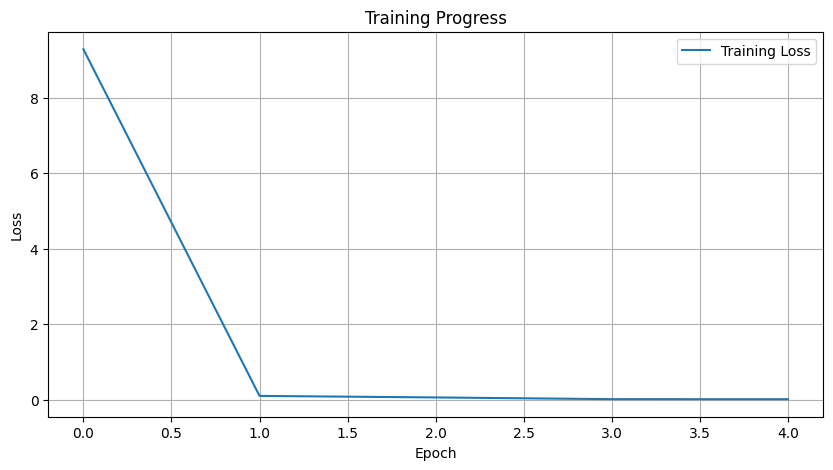

Current epoch: 5
Best loss: 0.0179
Current loss: 0.0179


Epoch 10/50: 100%|██████████| 50/50 [7:59:29<00:00, 575.38s/it, loss=0.00486]     


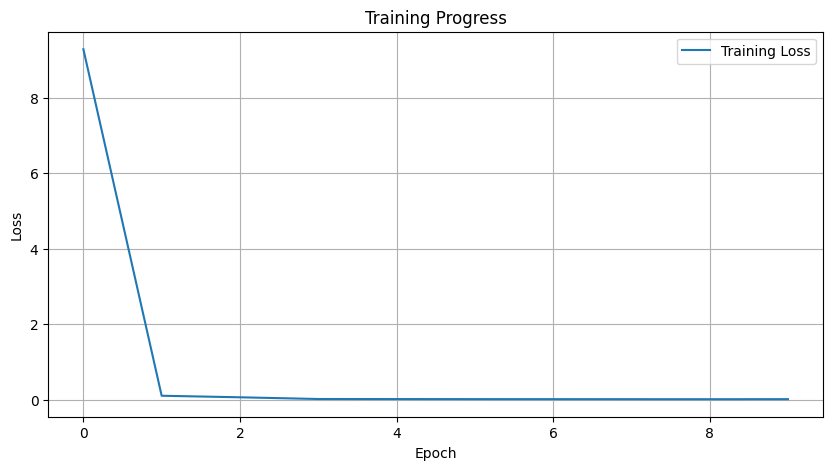

Current epoch: 10
Best loss: 0.0139
Current loss: 0.0152


Epoch 11/50:  38%|███▊      | 19/50 [17:38<28:47, 55.72s/it, loss=0.00975] 


KeyboardInterrupt: 

In [8]:
# 在训练循环之前，添加保存路径
MODEL_SAVE_PATH = 'best_unet_model.pth'  # 保存最佳模型
CHECKPOINT_DIR = 'checkpoints'  # 保存检查点的目录

# 创建检查点目录
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

# 修改训练函数
def train_model(model, train_loader, criterion, optimizer, num_epochs, device, monitor):
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        try:  # 添加 try-except 以便能够优雅地处理中断
            # Progress bar using tqdm
            from tqdm import tqdm
            pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
            
            for images, masks in pbar:
                images = images.float().to(device)
                masks = masks.float().to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                pbar.set_postfix({'loss': loss.item()})
            
            # 计算平均损失
            avg_loss = running_loss / len(train_loader)
            monitor.update(avg_loss)
            
            # 保存检查点
            checkpoint_path = os.path.join(CHECKPOINT_DIR, f'model_epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, checkpoint_path)
            
            # 如果是最佳模型，单独保存
            if avg_loss < best_loss:
                best_loss = avg_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': best_loss,
                }, MODEL_SAVE_PATH)
                print(f"Saved best model with loss: {best_loss:.4f}")
            
            if (epoch + 1) % 5 == 0:  # 每5个epoch显示一次进度
                monitor.plot_progress()
                monitor.print_stats()
                
        except KeyboardInterrupt:
            print("\nTraining interrupted by user")
            print(f"Saving model at epoch {epoch+1}...")
            # 保存中断时的模型
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, 'interrupted_model.pth')
            print("Model saved. You can continue training later.")
            break
            
    return model

# 如果要继续训练，添加这个函数
def continue_training(model, optimizer, start_epoch, num_epochs):
    checkpoint = torch.load('interrupted_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    
    print(f"Continuing training from epoch {start_epoch+1}")
    train_model(model, train_loader, criterion, optimizer, 
                num_epochs-start_epoch, device, monitor)

# 使用方法：
# 1. 正常开始训练
train_model(model, train_loader, criterion, optimizer, NUM_EPOCHS, device, monitor)

# 2. 如果训练被中断，之后可以继续训练
# continue_training(model, optimizer, start_epoch, NUM_EPOCHS)

## 6. Visualize Training Results

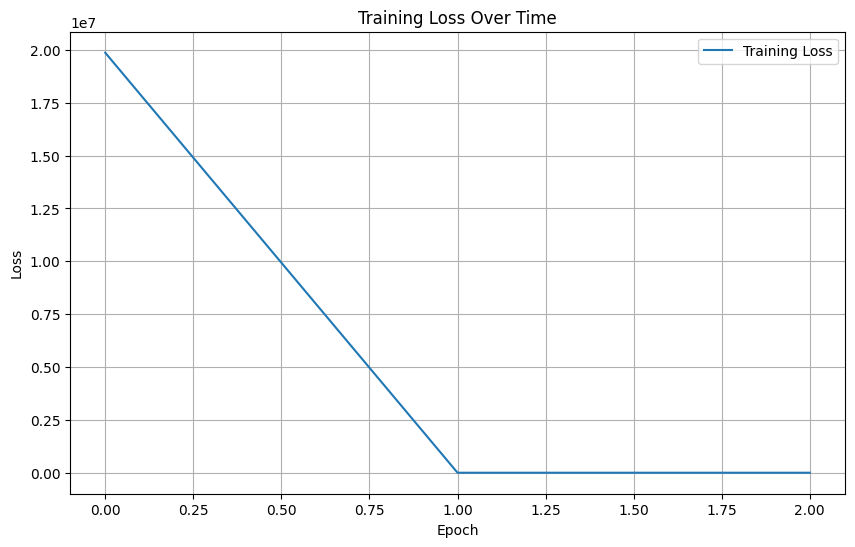

In [36]:
def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_history(history)
